# Why is Random forest so popular and how deep is the rabbit hole ?

We know for a simple fact that the opinions of a group are collectively more accurate than the opinions of an individual. So if a group of 10 people with similar skills are told to find the number of pigeons in New York , each would come up with a different answer. However if their thinking process is similar we would surely see that the average of all of the answers would be close of each individuals answer.

Based on these principles we find ensamble models are better suited because they give the collective results of many models. So if a single decision tree can give a certain answer , a collection of trees or forest with different types of trees will give a better answer.

Thats all fine but can we try to build something of this sort and plug it into a neural network ? lets find out .

Similarly we have seen that RESNET introduced us with the concept of residual connections or skip connections. When we want to train a very deep network , the error gradients tend toward zero as we go deeper and deeper into the network. So in order for the signals to propagate we have skip connections or residual connections , these connections bypass the layers where gradients are small and propagate the signal to subsequent layers , in this way , the gradients are propagated effecdtively and the overall performance is also increased.

In this notebook we have tried to have both these concepts and in a single neural network and see how far we can push the envelope to get as closer to the accuracy as possible. 

# Data Input

The following code items input the data from the files

In [200]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autismdiagnosis/Autism_Prediction/sample_submission.csv
/kaggle/input/autismdiagnosis/Autism_Prediction/train.csv
/kaggle/input/autismdiagnosis/Autism_Prediction/test.csv


In [201]:
data_train = pd.read_csv('/kaggle/input/autismdiagnosis/Autism_Prediction/train.csv')
data_test = pd.read_csv('/kaggle/input/autismdiagnosis/Autism_Prediction/test.csv')

# Class Imbalance 

A very common problem with classification problems is class impalance , this happens when we have one of the classes vastly outnumbering the other class . If we train out models directly on this data then we will have a significant bias towards our majority class . There are several ways of dealing with class imbalance .

One of them is to oversample the lesser class or under sample the higher class while creating our train test splits. This way we can have the desired balance but we can only do this when we have a huge amount of data and or batch size is very less in comparison to the size of the dataset.

Another approach is to fill the dataset with dummy data which mimics the lesser class , algotithms like SMOTE and generative models are often used to achieve this . These can sometimes work or sometimes they give erratic results depending on the spread of the data.

Yet another way is to calculate a factor or a ratio between one class and another and to use this factor as the output bias of the neural network. This bias regulates the losses and balances out the class imbalance.

We can use any of them . We have calculated the bias for reference but not used it. Instead we have used an algorithm similar to SMOTE.

We calculate a bias term for supplying to the neural network in case of class imbalance . 

In [202]:
bias = np.log((data_train['Class/ASD'] == 1).sum()/(data_train['Class/ASD'] == 0).sum())

In [203]:
data_train

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,0,1,0,0,0,0,0,0,1,...,m,Hispanic,no,no,New Zealand,no,12.999501,18 and more,Self,0
796,797,0,1,1,0,0,1,0,1,1,...,m,White-European,no,no,Cyprus,no,13.561518,18 and more,Self,0
797,798,0,0,0,0,0,0,0,0,0,...,m,South Asian,yes,no,New Zealand,no,2.653177,18 and more,Self,0
798,799,0,0,0,0,0,0,0,0,0,...,f,?,no,no,Canada,no,9.069342,18 and more,Self,0


In [204]:
data_test

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation
0,1,1,1,0,0,1,1,0,0,1,...,15.599481,m,White-European,yes,no,India,no,12.399055,18 and more,Self
1,2,1,0,0,0,0,0,0,1,0,...,27.181099,m,Asian,no,no,Mexico,no,6.551598,18 and more,Self
2,3,1,1,1,0,1,1,0,1,1,...,31.643906,m,White-European,yes,no,Egypt,no,3.180663,18 and more,Self
3,4,0,0,0,0,0,0,0,0,0,...,25.369210,m,?,no,no,India,no,2.220766,18 and more,Self
4,5,0,0,0,1,0,0,0,0,0,...,9.078580,m,?,no,no,Italy,no,7.252028,18 and more,Self
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,1,1,0,0,1,0,0,1,1,...,23.099434,m,Black,no,no,Azerbaijan,no,-1.915659,18 and more,Self
196,197,1,0,0,0,0,0,0,0,0,...,13.935726,m,Others,no,no,India,no,0.520234,18 and more,Self
197,198,1,0,0,0,0,0,1,0,1,...,22.760041,m,?,no,no,New Zealand,no,3.498948,18 and more,?
198,199,0,1,0,0,0,0,0,1,0,...,24.352584,f,?,no,no,United States,no,5.594550,18 and more,Self


# Pre processing 

The below steps are used to pre process the input data . We have discussed the preprocessing steps in detail in [this](https://www.kaggle.com/code/ezzzio/autism-prediction-0-85805-score) notebook

In [205]:
country_label = (data_train[data_train['Class/ASD'] == 1]['contry_of_res'].value_counts() / data_train[data_train['Class/ASD'] == 0]['contry_of_res'].value_counts() * data_train['contry_of_res'].value_counts()).sort_values(ascending=False)
country_label = country_label.map(lambda x : 0 if np.isnan(x) else x)
country_label = dict((country_label - min(country_label))/(max(country_label) - min(country_label)))

for item in ['Uruguay', 'Lebanon', 'Philippines']:
    country_label[item] = 0

In [206]:
eth_label = data_train.loc[:,['ethnicity','Class/ASD']]
mapper = {
    '?' : 'others',
    'Others' : 'others'
}
eth_label['ethnicity'] = eth_label['ethnicity'].map(lambda x : mapper[x] if x in mapper else x)
eth_label = (eth_label[eth_label['Class/ASD'] == 1]['ethnicity'].value_counts() / eth_label[eth_label['Class/ASD'] == 0]['ethnicity'].value_counts() * eth_label['ethnicity'].value_counts()).sort_values(ascending=False)
eth_label = eth_label.map(lambda x : 0 if np.isnan(x) else x)
eth_label = dict((eth_label - min(eth_label))/(max(eth_label) - min(eth_label)))
eth_label


{'White-European': 1.0,
 'others': 0.040928171940439864,
 'Pasifika': 0.0322959672093029,
 'Black': 0.030080542629396453,
 'Middle Eastern ': 0.027970614458056983,
 'Latino': 0.022876310106589557,
 'Asian': 0.018604356772025682,
 'South Asian': 0.01438993700253214,
 'Hispanic': 0.011245917153239403,
 'Turkish': 0.0}

In [207]:
def preprocess(data : pd.DataFrame):
    data_temp = data.copy()
    data_temp = data_temp.drop(['age_desc','relation'],axis = 1)
    data_temp['gender'] = data_temp['gender'].map(lambda x : 1 if x == 'm' else 0)
    data_temp['used_app_before'] = data_temp['used_app_before'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['jaundice'] = data_temp['jaundice'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['austim'] = data_temp['austim'].map(lambda x : 1 if x == 'yes' else 0)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(lambda x : 'others' if (x == 'Others' or x == '?') else x)
    data_temp['ethnicity'] = data_temp['ethnicity'].map(eth_label)
    data_temp['age'] = (data_temp['age'] - min(data_temp['age']))/(max(data_temp['age']) - min(data_temp['age']))
    data_temp['result'] = (data_temp['result'] - min(data_temp['result']))/(max(data_temp['result']) - min(data_temp['result']))
    data_temp['contry_of_res'] = data_temp['contry_of_res'].map(country_label)
    data_temp = data_temp.drop(['ID'],axis = 1)
    return data_temp

In [208]:
data_train_preprocess = preprocess(data_train)

In [209]:
data_train_preprocess

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,0.408726,0,0.040928,0,0,0.007444,0,0.567913,0
1,0,0,0,0,0,0,0,0,0,0,0.519141,1,0.040928,0,0,0.021693,0,0.381655,0
2,1,1,1,1,1,1,1,1,1,1,0.053743,1,1.000000,0,1,1.000000,0,0.954452,1
3,0,0,0,0,0,0,0,0,0,0,0.240288,0,0.040928,0,0,1.000000,0,0.382630,0
4,0,0,0,0,0,0,0,0,0,0,0.466748,1,0.040928,0,0,0.000000,0,0.061865,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0,1,0,0,0,0,0,0,1,1,0.159997,1,0.011246,0,0,0.007121,0,0.870236,0
796,0,1,1,0,0,1,0,1,1,1,0.207330,1,1.000000,0,0,0.014060,0,0.895793,0
797,0,0,0,0,0,0,0,0,0,0,0.034503,1,0.014390,1,0,0.007121,0,0.399753,0
798,0,0,0,0,0,0,0,0,0,0,0.157889,0,0.040928,0,0,0.090387,0,0.691518,0


In [210]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(data_train_preprocess.drop('Class/ASD',axis=1),data_train_preprocess['Class/ASD'],test_size=0.25, random_state=42)

In [211]:
x_train

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result
290,0,0,0,0,0,0,0,0,0,0,0.304884,0,0.040928,0,0,0.021693,0,0.539276
158,1,0,0,0,1,0,0,0,1,0,0.333177,1,0.022876,0,0,0.010545,0,0.641369
69,1,1,1,1,0,1,1,1,1,0,0.406521,0,0.030081,0,0,0.338164,0,0.842640
517,1,1,1,1,1,1,1,0,1,1,0.450182,0,1.000000,0,0,1.000000,0,0.851028
131,0,0,0,0,0,0,0,1,1,1,0.297056,1,0.040928,0,1,0.007121,0,0.217349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,1,0,0,0,0,0,1,0,1,0.618596,1,0.018604,0,0,0.007121,0,0.296000
106,0,0,0,1,0,0,0,1,0,1,0.186795,1,0.040928,0,0,0.008436,1,0.890814
270,1,0,0,0,1,0,0,1,0,1,0.095816,0,0.027971,0,0,0.000000,0,0.869212
435,1,1,1,1,1,0,1,0,1,1,0.458104,1,1.000000,0,0,0.060693,0,0.809920


In [212]:
y_train

290    0
158    1
69     0
517    1
131    0
      ..
71     0
106    0
270    0
435    0
102    0
Name: Class/ASD, Length: 600, dtype: int64

In [213]:
y_test.value_counts()

0    158
1     42
Name: Class/ASD, dtype: int64

In [214]:
y_train

290    0
158    1
69     0
517    1
131    0
      ..
71     0
106    0
270    0
435    0
102    0
Name: Class/ASD, Length: 600, dtype: int64

In [215]:
x_test

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result
696,1,1,0,0,0,0,0,1,1,0,0.129217,0,1.000000,0,0,0.015622,0,0.885370
667,0,0,0,0,0,0,0,0,0,0,0.264828,1,0.040928,0,0,0.021693,0,0.573750
63,0,0,0,0,0,0,0,0,0,0,0.130712,1,0.027971,0,0,0.021693,0,0.950857
533,0,0,0,0,0,0,0,1,0,0,0.221381,1,0.040928,0,0,0.007444,0,0.718210
66,0,0,0,0,0,0,0,1,1,0,0.156947,0,0.032296,0,0,0.008436,0,0.342264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0,0,0,0,0,0,0,0,0,1,0.239719,1,0.040928,0,0,0.007121,0,0.658582
650,1,0,1,0,0,0,0,0,0,0,0.285242,1,1.000000,1,0,0.000000,0,0.718505
181,0,0,0,0,0,0,0,0,0,1,0.431558,0,0.040928,0,0,0.000000,0,0.210439
790,1,0,1,1,1,1,1,0,1,0,0.138256,1,0.040928,0,0,0.021693,0,0.499479


In [216]:
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)

(200, 18)
(200,)
(600, 18)
(600,)


In [217]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks

ovr = ADASYN()
und = TomekLinks()
# x_train_smote,y_train_smote = ovr.fit_resample(x_train,y_train)
x_train_smote,y_train_smote = und.fit_resample(x_train,y_train)

In [218]:
# print(x_train_ads.shape)
# print(y_train_ads.shape)
# print(x_train_tmk.shape)
# print(y_train_tmk.shape)


# from imblearn.over_sampling import ADASYN
# from imblearn.under_sampling import TomekLinks

# ovr = ADASYN()
# und = TomekLinks()
# x_train_ads,y_train_ads = ovr.fit_resample(x_train,y_train)
# x_train_tmk,y_train_tmk = und.fit_resample(x_train,y_train)

# Model architecture

The below code build a three headed ensamble type neural net followed by a very deep dense layer with residual connections. This model is just to demonstrate the technique on how to build such models in tensorflow and keras.

In [219]:
input_layer = tf.keras.Input(shape = (x_train_smote.shape[1],))
input_dense = tf.keras.layers.Dense(64)(input_layer)

hidden_layer1 = tf.keras.layers.Dense(256, activation="relu",  kernel_regularizer=tf.keras.regularizers.L1(1e-2))(input_layer)
hidden_layer1 = tf.keras.layers.Dense(64, activation="relu")(hidden_layer1)

hidden_layer2 = tf.keras.layers.Dense(256, activation="relu",  kernel_regularizer=tf.keras.regularizers.L2(1e-2))(input_layer)
hidden_layer2 = tf.keras.layers.Dense(64, activation="relu")(hidden_layer2)


hidden_layer3 = tf.keras.layers.Dense(256, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(1e-2))(input_layer)
hidden_layer3 = tf.keras.layers.Dense(64, activation="relu")(hidden_layer3)

hidden_layer = tf.keras.layers.Add()([hidden_layer1,hidden_layer2,hidden_layer3])

skip_layer1 = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(1e-2))(hidden_layer)
skip_layer1 = tf.keras.layers.Dropout(0.1)(skip_layer1)
skip_layer1 = tf.keras.layers.Dense(128, activation="relu")(skip_layer1)
skip_layer1 = tf.keras.layers.Dropout(0.1)(skip_layer1)
skip_layer1 = tf.keras.layers.Dense(128, activation="relu")(skip_layer1)
skip_layer1 = tf.keras.layers.Dropout(0.1)(skip_layer1)
skip_layer1 = tf.keras.layers.Dense(64, activation="relu")(skip_layer1)
skip_layer1 = tf.keras.layers.Add()([skip_layer1,hidden_layer])

skip_layer2 = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(1e-2))(skip_layer1)
skip_layer2 = tf.keras.layers.Dropout(0.1)(skip_layer2)
skip_layer2 = tf.keras.layers.Dense(128, activation="relu")(skip_layer2)
skip_layer2 = tf.keras.layers.Dropout(0.1)(skip_layer2)
skip_layer2 = tf.keras.layers.Dense(128, activation="relu")(skip_layer2)
skip_layer2 = tf.keras.layers.Dropout(0.1)(skip_layer2)
skip_layer2 = tf.keras.layers.Dense(64, activation="relu")(skip_layer2)
skip_layer2 = tf.keras.layers.Add()([skip_layer2,skip_layer1])

skip_layer3 = tf.keras.layers.Dense(128, activation="relu",kernel_regularizer=tf.keras.regularizers.L1(1e-2))(skip_layer2)
skip_layer3 = tf.keras.layers.Dropout(0.1)(skip_layer3)
skip_layer3 = tf.keras.layers.Dense(128, activation="relu")(skip_layer3)
skip_layer3 = tf.keras.layers.Dropout(0.1)(skip_layer3)
skip_layer3 = tf.keras.layers.Dense(128, activation="relu")(skip_layer3)
skip_layer3 = tf.keras.layers.Dropout(0.1)(skip_layer3)
skip_layer3 = tf.keras.layers.Dense(64, activation="relu")(skip_layer3)
skip_layer3 = tf.keras.layers.Add()([skip_layer3,skip_layer2])

output_layer = tf.keras.layers.Dense(1, activation = 'sigmoid',name="output")(skip_layer3)
model = tf.keras.Model(inputs = input_layer,outputs = output_layer)

# bias_initializer = tf.keras.initializers.Constant(bias)
    

In [220]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
dense_115 (Dense)               (None, 256)          4864        input_7[0][0]                    
__________________________________________________________________________________________________
dense_117 (Dense)               (None, 256)          4864        input_7[0][0]                    
__________________________________________________________________________________________________
dense_119 (Dense)               (None, 256)          4864        input_7[0][0]                    
____________________________________________________________________________________________

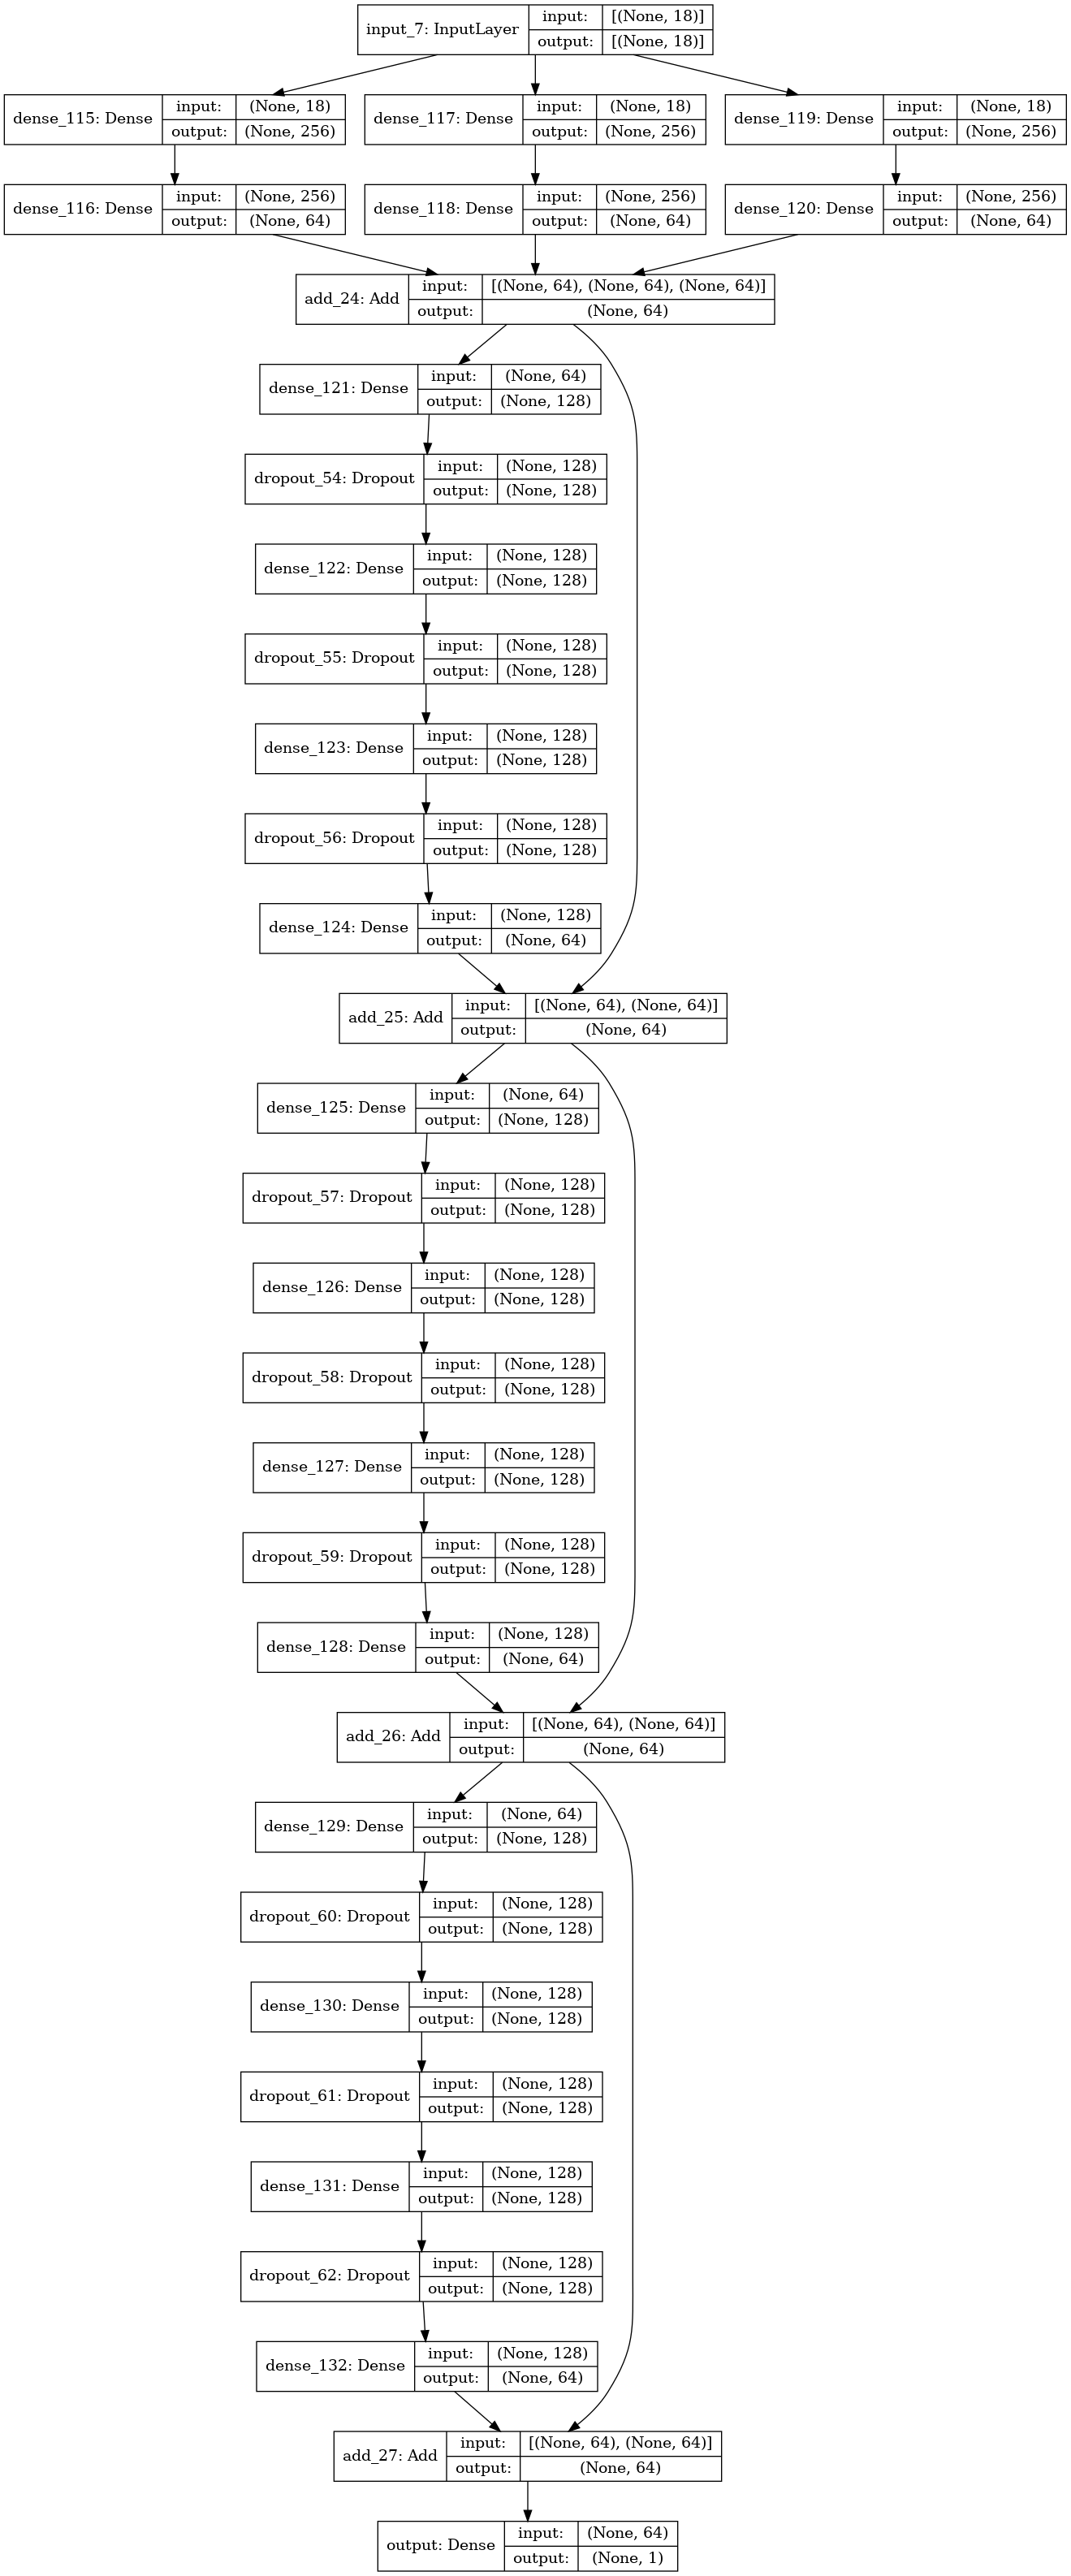

In [221]:
tf.keras.utils.plot_model(model,show_shapes = True,show_layer_names = True)

In [222]:
## Jkono ekta use koris AUC or Accuracy

model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=tf.keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[tf.keras.metrics.Accuracy(),tf.keras.metrics.BinaryAccuracy()],
    
)


# model.compile(
#     optimizer=tf.keras.optimizers.Adam(),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=[tf.keras.metrics.BinaryAccuracy()]
# )


In [223]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks=[
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5,
        verbose=1,
        min_lr=0.00001,
    ),
    
]

In [224]:
history = model.fit(
    x_train_smote,
    y_train_smote,
    batch_size=20,
    epochs=100,
    verbose=1,
    callbacks= callbacks,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_test, y_test),
)

Epoch 1/100
29/29 [==============================] - 3s 26ms/step - loss: 22.4961 - accuracy: 0.0000e+00 - binary_accuracy: 0.8441 - val_loss: 18.5578 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8600
Epoch 2/100
29/29 [==============================] - 0s 12ms/step - loss: 15.4650 - accuracy: 0.0000e+00 - binary_accuracy: 0.8757 - val_loss: 12.3356 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8600
Epoch 3/100
29/29 [==============================] - 0s 13ms/step - loss: 9.8224 - accuracy: 0.0000e+00 - binary_accuracy: 0.8879 - val_loss: 7.4177 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8750
Epoch 4/100
29/29 [==============================] - 0s 12ms/step - loss: 5.5366 - accuracy: 0.0000e+00 - binary_accuracy: 0.8984 - val_loss: 3.8440 - val_accuracy: 0.0000e+00 - val_binary_accuracy: 0.8650
Epoch 5/100
29/29 [==============================] - 0s 12ms/step - loss: 2.6198 - accuracy: 0.0000e+00 - binary_accuracy: 0.9002 - val_loss: 1.6502 - val_accuracy: 0.0000e

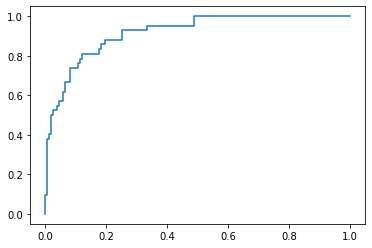

0.9172694394213382


In [225]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
data_test_pred = preprocess(data_test)
out = model.predict(x_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, out)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.show()
print(auc_keras)

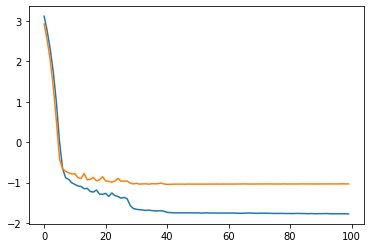

In [226]:
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))

In [227]:
out = model.predict(data_test_pred)
out_pd = pd.DataFrame({'ID':data_test['ID'],
              'Class/ASD':pd.Series(out.flatten(),name = 'Class/ASD')})
out_pd.to_csv('submission.csv',index = False)

As we can see that we have significantly lesser loss and out bias variance tradeoff is quite low

In [228]:
out

array([[2.02223688e-01],
       [4.40126657e-03],
       [3.80064249e-01],
       [1.27485394e-03],
       [2.18293071e-03],
       [6.79850578e-04],
       [5.77798963e-01],
       [4.93882298e-02],
       [1.22943521e-03],
       [2.14049220e-03],
       [1.19793415e-03],
       [6.93318248e-03],
       [7.81685114e-04],
       [5.06056726e-01],
       [1.78718567e-03],
       [3.36616993e-01],
       [9.00258720e-01],
       [9.29642916e-01],
       [1.60717964e-03],
       [4.74315882e-03],
       [7.66100645e-01],
       [3.63122404e-01],
       [9.25865412e-01],
       [9.26507473e-01],
       [2.22355127e-03],
       [1.09386444e-03],
       [9.89952981e-02],
       [6.35093987e-01],
       [3.03806365e-02],
       [1.06293708e-01],
       [1.30206347e-03],
       [2.78581083e-02],
       [9.58560348e-01],
       [9.42641497e-03],
       [7.96911836e-01],
       [7.88179457e-01],
       [7.31862187e-02],
       [4.18661177e-01],
       [1.04805827e-03],
       [5.95315993e-02],


In [229]:
y_test.value_counts()

0    158
1     42
Name: Class/ASD, dtype: int64

In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score

data_test_pred = preprocess(data_test)
out = model.predict(x_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, out)
auc_keras = auc(fpr_keras, tpr_keras)

# Calculate predictions based on output probabilities
y_pred = (out > 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy : ",(149+27)/(149+11+13+27))

Confusion Matrix:
[[141  17]
 [ 11  31]]
Precision: 0.6458333333333334
Recall: 0.7380952380952381
F1 Score: 0.6888888888888889
Accuracy :  0.88


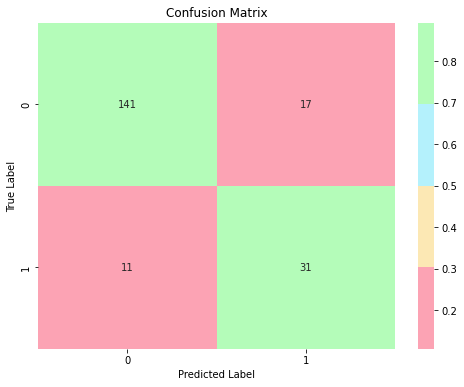

In [231]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Define custom color palette
colors = ["#fca3b4", "#fce8b4", "#b4f1fc", "#b4fcb9"]

# Normalize the confusion matrix
confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the confusion matrix as a heatmap with custom colors
sns.heatmap(confusion_normalized, annot=confusion, fmt='d', cmap=sns.color_palette(colors))

# Add title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()


Text(33.0, 0.5, 'Actual Values')

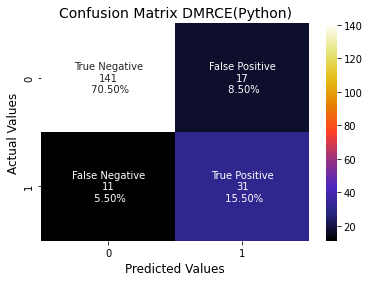

In [237]:
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in
                confusion.flatten()]
group_percentages = [" {0:.2%}".format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt='', cmap='CMRmap')
plt.title('Confusion Matrix DMRCE(Python)', fontsize = 14) # title with fontsize 20
plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Actual Values', fontsize = 12) # y-axis label with fontsize 15

In [232]:
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)
print("\n\nTest Loss", loss_and_metrics[0])
print("\n\nTest AUC", loss_and_metrics[2])

7/7 - 0s - loss: 0.3566 - accuracy: 0.0000e+00 - binary_accuracy: 0.8600


Test Loss 0.3565780222415924


Test AUC 0.8600000143051147


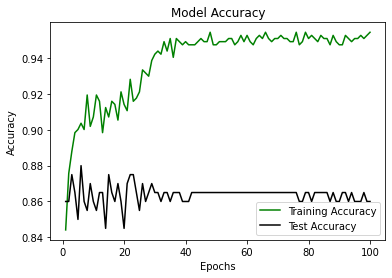

In [235]:
 import matplotlib.pyplot as plt

# # Obtain model accuracy values during training
 train_accuracy = history.history['binary_accuracy']
test_accuracy = history.history['val_binary_accuracy']

# # Create a list of epochs
 epochs = range(1, len(train_accuracy) + 1)

# # Plot model accuracy
 plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
 plt.plot(epochs, test_accuracy, 'k', label='Test Accuracy')
 plt.title('Model Accuracy')
 plt.xlabel('Epochs')
 plt.ylabel('Accuracy')
 plt.legend()

# # Show the plot
 plt.show()


import matplotlib.pyplot as plt

# Obtain model accuracy values during training
# train_accuracy = history.history['auc']
# test_accuracy = history.history['val_auc']

# Create a list of epochs
# epochs = range(1, len(train_accuracy) + 1)
# plt.figure(figsize=(8, 6))

# Plot model accuracy
# plt.plot(epochs, train_accuracy, 'b', label='Training AUC')
# plt.plot(epochs, test_accuracy, 'r', label='Test AUC')
# plt.title('Model AUC')
# plt.xlabel('Epochs')
# plt.ylabel('AUC')
# plt.legend()

# Show the plot
# plt.show()


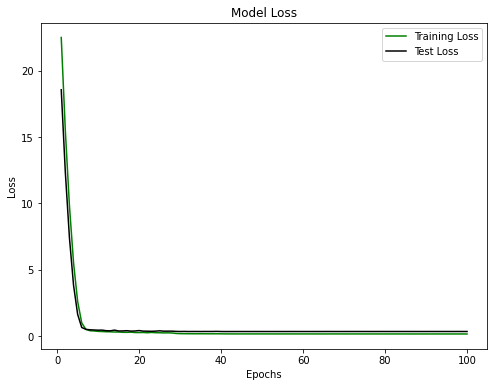

In [234]:
import matplotlib.pyplot as plt

# Obtain model loss values during training
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create a list of epochs
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(8, 6))

# Plot model loss
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, test_loss, 'k', label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()